In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import timeit
%matplotlib inline

## Задание 2

Реализуйте произведение матриц $A\in Mat(N\times K)$, $B\in Mat(K\times M)$ согласно определению
$$
C_{n,m}=\sum_{k=1}^K A_{n,k}B_{k,m}.
$$
Сравните быстродействие реализаций на основе numpy.sum, с помощью numba и стандартный метод numpy.dot.
Насколько полно используется процессор? 
Сколько используется памяти?

In [2]:
def no_nb_matmul(in_mtrx1: np.ndarray, in_mtrx2: np.ndarray) -> np.ndarray:
    num_rows1, num_cols1 = in_mtrx1.shape
    num_cols2 = in_mtrx2.shape[1]
    # num_rows2, num_cols2 = in_mtrx2.shape
    # assert (num_cols1 == num_rows2, "Incorrect input matrices sizes")
    out_mtrx = np.zeros(shape=(num_rows1, num_cols2), dtype=np.float64)
    for n in range(num_rows1):
        for m in range(num_cols2):
            for k in range(num_cols1):
                out_mtrx[n, m] += in_mtrx1[n, k]*in_mtrx2[k, m]
    return out_mtrx

@nb.njit('float64[:,:](float64[:,:],float64[:,:])', parallel = False) # 2D-arrays
def nb_matmul(in_mtrx1: np.ndarray, in_mtrx2: np.ndarray) -> np.ndarray:
    num_rows1, num_cols1 = in_mtrx1.shape
    num_cols2 = in_mtrx2.shape[1]
    # num_rows2, num_cols2 = in_mtrx2.shape
    # assert (num_cols1 == num_rows2, "Incorrect input matrices sizes")
    out_mtrx = np.zeros(shape=(num_rows1, num_cols2), dtype=np.float64)
    for n in range(num_rows1):
        for m in range(num_cols2):
            for k in range(num_cols1):
                out_mtrx[n, m] += in_mtrx1[n, k]*in_mtrx2[k, m]
    return out_mtrx

def sum_matmul(in_mtrx1: np.ndarray, in_mtrx2: np.ndarray) -> np.ndarray:
    num_rows1, num_cols1 = in_mtrx1.shape
    num_cols2 = in_mtrx2.shape[1]
    out_mtrx = np.empty(shape=(num_rows1, num_cols2), dtype=np.float64)
    for n in range(num_rows1):
        for m in range(num_cols2):
            out_mtrx[n, m] = np.sum(in_mtrx1[n, :]*in_mtrx2[:, m])
    return out_mtrx

In [3]:
# generate input data
np.random.seed(0)
num_repetitions = 5

num_rows1 = 10
num_cols2 = 10
num_cols1 = 1000

mtrx1 = np.random.random(size=(num_rows1, num_cols1))
mtrx2 = np.random.random(size=(num_cols1, num_cols2))

vec1 = np.random.random(size=(1, num_cols1))
vec2 = np.random.random(size=(num_cols1, 1))

In [4]:
print("Matrix multiplication:")
print("Numba matmul:")
%timeit nb_matmul(mtrx1, mtrx2)
print("Numpy matmul:")
%timeit np.matmul(mtrx1, mtrx2)
print("Numpy sum matmul:")
%timeit sum_matmul(mtrx1, mtrx2)
print()

print("Vector multiplication:")
print("Numba matmul:")
%timeit nb_matmul(vec1, vec2)
print("Numpy matmul:")
%timeit np.matmul(vec1, vec2)
print("Numpy sum matmul:")
%timeit sum_matmul(vec1, vec2)

Matrix multiplication:
Numba matmul:
80.1 μs ± 661 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Numpy matmul:
16.9 μs ± 159 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
Numpy sum matmul:
546 μs ± 1.25 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Vector multiplication:
Numba matmul:
1.73 μs ± 20.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
Numpy matmul:
1.52 μs ± 7.96 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
Numpy sum matmul:
6.1 μs ± 97.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [16]:
# changing k-size
def get_runtime_vs_ksize(varying_size_k):
    num_rows1 = 10
    num_cols2 = 10
    num_cols1 = varying_size_k[-1]

    mtrx1 = np.random.random(size=(num_rows1, num_cols1))
    mtrx2 = np.random.random(size=(num_cols1, num_cols2))

    ksize_time_numba = np.empty_like(varying_size_k, dtype=np.float64)
    ksize_time_numpy = np.empty_like(varying_size_k, dtype=np.float64)
    ksize_time_sum = np.empty_like(varying_size_k, dtype=np.float64)

    for i, sz in enumerate(varying_size_k):
        ksize_time_numba[i] = timeit.timeit(stmt='my_matmul(mtrx1, mtrx2)',
                                    globals={"my_matmul": nb_matmul, "mtrx1": mtrx1[:,:sz], "mtrx2": mtrx2[:sz,:]}, number=10)
        ksize_time_numpy[i] = timeit.timeit(stmt='numpy_matmul(mtrx1, mtrx2)',
                                    globals={"numpy_matmul": np.matmul, "mtrx1": mtrx1[:,:sz], "mtrx2": mtrx2[:sz,:]}, number=10)
        ksize_time_sum[i] = timeit.timeit(stmt='sum_matmul(mtrx1, mtrx2)',
                                globals={"sum_matmul": sum_matmul, "mtrx1": mtrx1[:,:sz], "mtrx2": mtrx2[:sz,:]}, number=10)
    return ksize_time_numba, ksize_time_numpy, ksize_time_sum

varying_size_k = np.logspace(0, 5, 6, dtype=np.int32)
ksize_time_numba, ksize_time_numpy, ksize_time_sum = get_runtime_vs_ksize(varying_size_k)

In [17]:
# changing n-size
varying_size_n = np.logspace(0, 4, 5, dtype=np.int32)

num_rows1 = varying_size_n[-1]
num_cols2 = 10
num_cols1 = 10

mtrx1 = np.random.random(size=(num_rows1, num_cols1))
mtrx2 = np.random.random(size=(num_cols1, num_cols2))

nsize_time_numba = np.empty_like(varying_size_n, dtype=np.float64)
nsize_time_numpy = np.empty_like(varying_size_n, dtype=np.float64)
nsize_time_sum = np.empty_like(varying_size_n, dtype=np.float64)

for i, sz in enumerate(varying_size_n):
    nsize_time_numba[i] = timeit.timeit(stmt='my_matmul(mtrx1, mtrx2)',
                                globals={"my_matmul": nb_matmul, "mtrx1": mtrx1[:sz,:], "mtrx2": mtrx2}, number=10)
    nsize_time_numpy[i] = timeit.timeit(stmt='numpy_matmul(mtrx1, mtrx2)',
                                globals={"numpy_matmul": np.dot, "mtrx1": mtrx1[:sz,:], "mtrx2": mtrx2}, number=10)
    nsize_time_sum[i] = timeit.timeit(stmt='sum_matmul(mtrx1, mtrx2)',
                              globals={"sum_matmul": sum_matmul, "mtrx1": mtrx1[:sz,:], "mtrx2": mtrx2}, number=10)

In [18]:
# changing m-size
varying_size_m = np.logspace(0, 4, 5, dtype=np.int32)

num_rows1 = 10
num_cols2 = varying_size_m[-1]
num_cols1 = 10

mtrx1 = np.random.random(size=(num_rows1, num_cols1))
mtrx2 = np.random.random(size=(num_cols1, num_cols2))

msize_time_numba = np.empty_like(varying_size_m, dtype=np.float64)
msize_time_numpy = np.empty_like(varying_size_m, dtype=np.float64)
msize_time_sum = np.empty_like(varying_size_m, dtype=np.float64)

for i, sz in enumerate(varying_size_m):
    msize_time_numba[i] = timeit.timeit(stmt='my_matmul(mtrx1, mtrx2)',
                                globals={"my_matmul": nb_matmul, "mtrx1": mtrx1, "mtrx2": mtrx2[:,:sz]}, number=10)
    msize_time_numpy[i] = timeit.timeit(stmt='numpy_matmul(mtrx1, mtrx2)',
                                globals={"numpy_matmul": np.dot, "mtrx1": mtrx1, "mtrx2": mtrx2[:,:sz]}, number=10)
    msize_time_sum[i] = timeit.timeit(stmt='sum_matmul(mtrx1, mtrx2)',
                              globals={"sum_matmul": sum_matmul, "mtrx1": mtrx1, "mtrx2": mtrx2[:,:sz]}, number=10)

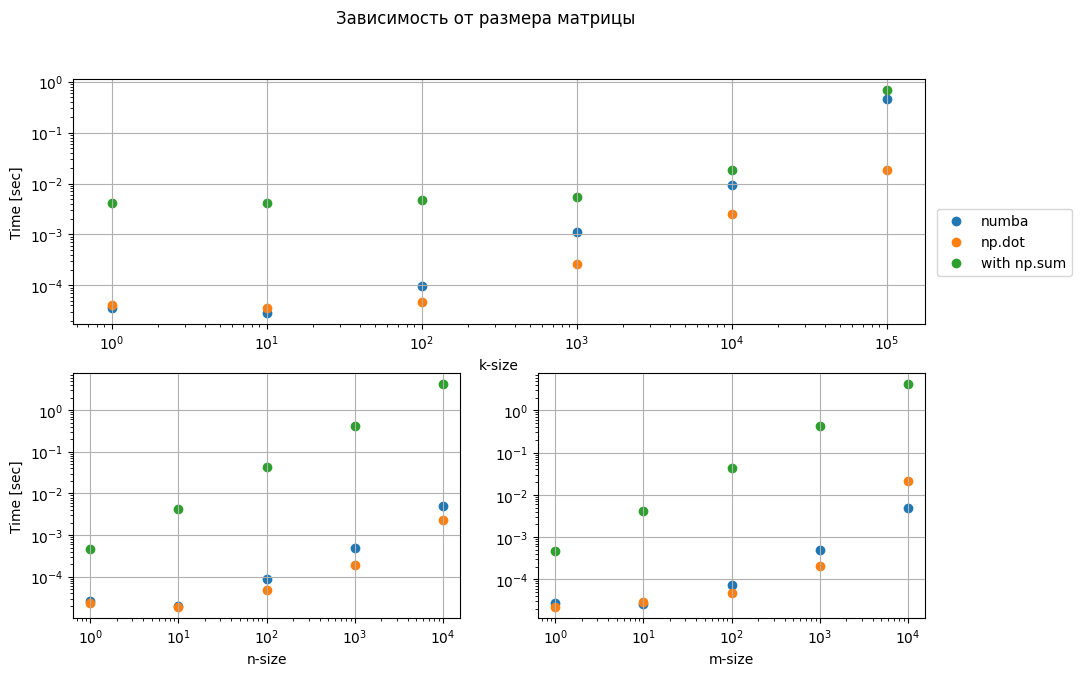

In [19]:
fig1 = plt.figure(figsize=[11,7])
fig1.suptitle(r'Зависимость от размера матрицы')

ax_1 = fig1.add_subplot(211)
ax_1.scatter(varying_size_k, ksize_time_numba, label="numba")
ax_1.scatter(varying_size_k, ksize_time_numpy, label="np.dot")
ax_1.scatter(varying_size_k, ksize_time_sum, label="with np.sum")
ax_1.set_xlabel('k-size')
ax_1.set_ylabel('Time [sec]')
ax_1.set_xscale('log')
ax_1.set_yscale('log')
ax_1.legend(bbox_to_anchor=(1.18, 0.5))
ax_1.grid()

ax_2 = fig1.add_subplot(223)
ax_2.scatter(varying_size_n, nsize_time_numba, label="numba")
ax_2.scatter(varying_size_n, nsize_time_numpy, label="np.dot")
ax_2.scatter(varying_size_n, nsize_time_sum, label="with np.sum")
ax_2.set_xlabel('n-size')
ax_2.set_ylabel('Time [sec]')
ax_2.set_xscale('log')
ax_2.set_yscale('log')
ax_2.grid()

ax_3 = fig1.add_subplot(224)
ax_3.scatter(varying_size_m, msize_time_numba, label="numba")
ax_3.scatter(varying_size_m, msize_time_numpy, label="np.dot")
ax_3.scatter(varying_size_m, msize_time_sum, label="with np.sum")
ax_3.set_xlabel('m-size')
ax_3.set_xscale('log')
ax_3.set_yscale('log')
ax_3.grid()

plt.show()

## Задание 3

Составьте модель использования вычислительных ресурсов функцией на основе numba.jit из предыдущего пункта.
Размеры матриц должны быть параметрами модели.
Проведите вычислительные эксперименты, чтобы подобрать параметры модели.
Экстраполируйте результат на большие матрицы, сделайте экспериментальную проверку.

Мы рассматриваем матрицы $A\in Mat(N\times K)$, $B\in Mat(K\times M)$. Исследуем зависимость времени выполнения от размера $K$. Ожидаемую сложность выполнения программы можно представить так:
$$T(K)=aK+b$$
- $b$ не зависит от размера $K$, можно назвать его временем на запуск
- Считывание строки матрицы $A$ делается за $O(K)$
- Считывание столбца матрицы $B$ делается за $O(K)$
- Произведение $K$ пар элементов и их суммирование за $O(K)$
Константа перед переменной размера $K$ зависит от $M$ и $N$, тк это делается $MN$ раз.

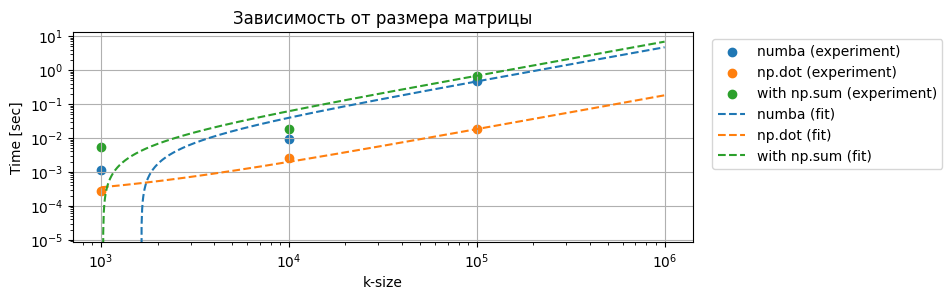

In [20]:
numba_fit_coeffs = np.polyfit(varying_size_k, ksize_time_numba, 1)
numpy_fit_coeffs = np.polyfit(varying_size_k, ksize_time_numpy, 1)
sum_fit_coeffs = np.polyfit(varying_size_k, ksize_time_sum, 1)

numba_poly = np.poly1d(numba_fit_coeffs)
numpy_poly = np.poly1d(numpy_fit_coeffs)
sum_poly = np.poly1d(sum_fit_coeffs)

ksize_for_plot = np.logspace(3, 6, 1000)


fig2 = plt.figure(figsize=[8,6])
ax_1 = fig2.add_subplot(211)
ax_1.set_title(r'Зависимость от размера матрицы')
ax_1.scatter(varying_size_k[3:], ksize_time_numba[3:], label="numba (experiment)")
ax_1.scatter(varying_size_k[3:], ksize_time_numpy[3:], label="np.dot (experiment)")
ax_1.scatter(varying_size_k[3:], ksize_time_sum[3:], label="with np.sum (experiment)")
ax_1.plot(ksize_for_plot, numba_poly(ksize_for_plot), "--", label="numba (fit)")
ax_1.plot(ksize_for_plot, numpy_poly(ksize_for_plot), "--", label="np.dot (fit)")
ax_1.plot(ksize_for_plot, sum_poly(ksize_for_plot), "--",label="with np.sum (fit)")
ax_1.set_xlabel('k-size')
ax_1.set_ylabel('Time [sec]')
ax_1.set_xscale('log')
ax_1.set_yscale('log')
ax_1.legend(bbox_to_anchor=(1.02, 1))
ax_1.grid()
plt.show()

Проверим точность экстраполяции

Results K=100000
Numba: Experiment = 0.4402157000004081 sec, Theory = 0.46160237066561216 sec
Numpy: Experiment = 0.021125799998117145 sec, Theory = 0.018188105500295825 sec
Sum: Experiment = 0.6001328999991529 sec, Theory = 0.6776854391954642 sec
Results K=1000000
Numba: Experiment = 4.053782900002261 sec, Theory = 4.685268584481675 sec
Numpy: Experiment = 0.19106060000194702 sec, Theory = 0.1803293271251631 sec
Sum: Experiment = 7.412601800002449 sec, Theory = 6.840059171602048 sec


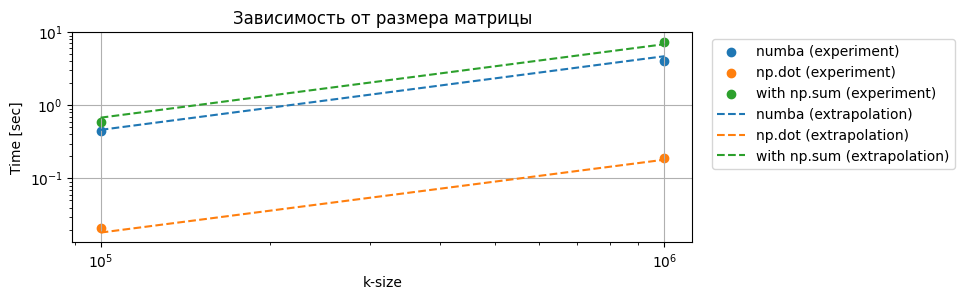

In [26]:
big_ksize = np.logspace(5, 6, 2, dtype=np.int32)
bigksize_time_numba, bigksize_time_numpy, bigksize_time_sum = get_runtime_vs_ksize(big_ksize)

ksize_for_plot = np.logspace(5, 6, 300)

for i in range(len(big_ksize)):
    print("Results K="+str(big_ksize[i]))
    print("Numba: Experiment = {} sec, Theory = {} sec".format(bigksize_time_numba[i], numba_poly(big_ksize[i])))
    print("Numpy: Experiment = {} sec, Theory = {} sec".format(bigksize_time_numpy[i], numpy_poly(big_ksize[i])))
    print("Sum: Experiment = {} sec, Theory = {} sec".format(bigksize_time_sum[i], sum_poly(big_ksize[i])))

fig3 = plt.figure(figsize=[8,6])
ax_1 = fig3.add_subplot(211)
ax_1.set_title(r'Зависимость от размера матрицы')
ax_1.scatter(big_ksize, bigksize_time_numba, label="numba (experiment)")
ax_1.scatter(big_ksize, bigksize_time_numpy, label="np.dot (experiment)")
ax_1.scatter(big_ksize, bigksize_time_sum, label="with np.sum (experiment)")
ax_1.plot(big_ksize, numba_poly(big_ksize), "--", label="numba (extrapolation)")
ax_1.plot(big_ksize, numpy_poly(big_ksize), "--", label="np.dot (extrapolation)")
ax_1.plot(big_ksize, sum_poly(big_ksize), "--",label="with np.sum (extrapolation)")
ax_1.set_xlabel('k-size')
ax_1.set_ylabel('Time [sec]')
ax_1.set_xscale('log')
ax_1.set_yscale('log')
ax_1.legend(bbox_to_anchor=(1.02, 1))
ax_1.grid()
plt.show()

## Задание 4

В простейшем алгоритме произведения матриц используются три цикла: перебирающие элементы $n$ и $m$  матрицы $C$
и суммирующие по $k$. 
Сравните время перемножения матриц в зависимости от порядка циклов.
Оцените объем кэшей разных уровней, проводя эксперименты для матриц разного размера.

In [ ]:
@nb.njit('float64[:,:](float64[:,:],float64[:,:])', parallel = False) # 2D-arrays
def nb_matmul_nmk(in_mtrx1: np.ndarray, in_mtrx2: np.ndarray) -> np.ndarray:
    num_rows1, num_cols1 = in_mtrx1.shape
    num_cols2 = in_mtrx2.shape[1]
    # num_rows2, num_cols2 = in_mtrx2.shape
    # assert (num_cols1 == num_rows2, "Incorrect input matrices sizes")
    out_mtrx = np.zeros(shape=(num_rows1, num_cols2), dtype=np.float64)
    for n in range(num_rows1):
        for m in range(num_cols2):
            for k in range(num_cols1):
                out_mtrx[n, m] += in_mtrx1[n, k]*in_mtrx2[k, m]
    return out_mtrx

@nb.njit('float64[:,:](float64[:,:],float64[:,:])', parallel = False) # 2D-arrays
def nb_matmul_nkm(in_mtrx1: np.ndarray, in_mtrx2: np.ndarray) -> np.ndarray:
    num_rows1, num_cols1 = in_mtrx1.shape
    num_cols2 = in_mtrx2.shape[1]
    # num_rows2, num_cols2 = in_mtrx2.shape
    # assert (num_cols1 == num_rows2, "Incorrect input matrices sizes")
    out_mtrx = np.zeros(shape=(num_rows1, num_cols2), dtype=np.float64)
    for n in range(num_rows1):
        for k in range(num_cols1):
            for m in range(num_cols2):
                out_mtrx[n, m] += in_mtrx1[n, k]*in_mtrx2[k, m]
    return out_mtrx

@nb.njit('float64[:,:](float64[:,:],float64[:,:])', parallel = False) # 2D-arrays
def nb_matmul_knm(in_mtrx1: np.ndarray, in_mtrx2: np.ndarray) -> np.ndarray:
    num_rows1, num_cols1 = in_mtrx1.shape
    num_cols2 = in_mtrx2.shape[1]
    # num_rows2, num_cols2 = in_mtrx2.shape
    # assert (num_cols1 == num_rows2, "Incorrect input matrices sizes")
    out_mtrx = np.zeros(shape=(num_rows1, num_cols2), dtype=np.float64)
    for k in range(num_cols1):
        for n in range(num_rows1):
            for m in range(num_cols2):
                out_mtrx[n, m] += in_mtrx1[n, k]*in_mtrx2[k, m]
    return out_mtrx

## Задание 5

In [ ]:
@nb.njit('float64[:,:](float64[:,:],float64[:,:])', parallel = True, nogil = False) # 2D-arrays
def nb_matmul_parallel(in_mtrx1: np.ndarray, in_mtrx2: np.ndarray) -> np.ndarray:
    num_rows1, num_cols1 = in_mtrx1.shape
    num_cols2 = in_mtrx2.shape[1]
    # num_rows2, num_cols2 = in_mtrx2.shape
    # assert (num_cols1 == num_rows2, "Incorrect input matrices sizes")
    out_mtrx = np.zeros(shape=(num_rows1, num_cols2), dtype=np.float64)
    for n in nb.prange(num_rows1):
        for m in range(num_cols2):
            for k in range(num_cols1):
                out_mtrx[n, m] += in_mtrx1[n, k]*in_mtrx2[k, m]
    return out_mtrx

## Задания.

1. Изучите реализацию многомерных массивов numpy.ndarray и работу с ними в numba.
Посмотрите ноутбук [FastPython.](../FastPython.ipynb) 

2. Реализуйте произведение матриц $A\in Mat(N\times K)$, $B\in Mat(K\times M)$ согласно определению
$$
C_{n,m}=\sum_{k=1}^K A_{n,k}B_{k,m}.
$$
Сравните быстродействие реализаций на основе numpy.sum, с помощью numba и стандартный метод numpy.dot.
Насколько полно используется процессор? 
Сколько используется памяти?

3. Составьте модель использования вычислительных ресурсов функцией на основе numba.jit из предыдущего пункта.
Размеры матриц должны быть параметрами модели.
Проведите вычислительные эксперименты, чтобы подобрать параметры модели.
Экстраполируйте результат на большие матрицы, сделайте экспериментальную проверку.

4. В простейшем алгоритме произведения матриц используются три цикла: перебирающие элементы $n$ и $m$  матрицы $C$
и суммирующие по $k$. 
Сравните время перемножения матриц в зависимости от порядка циклов.
Оцените объем кэшей разных уровней, проводя эксперименты для матриц разного размера.

5. Обновите функцию для перемножения матриц, используя несколько потоков с помощью numba.prange.
Обновите модель использования вычислительных ресурсов, принимая во внимание число потоков.
Оцените параметры модели из эксперимента.
Какое [параллельное ускорение](https://en.wikipedia.org/wiki/Amdahl%27s_law) вы получили?

6. Сможете ли вы реализовать реализовать на С более быстрый вариант перемножения матриц, чем на numba?

7. Реализуйте быстрое произведение матриц, например, используйте [алгоритм Штрассена](https://en.wikipedia.org/wiki/Strassen_algorithm).
Оцените, на матрицах какого размера быстрое произведение матриц быстрее, чем стандартная реализация.
Какой из методов дает меньшую погрешность вычислений?


# Дополнительные задания

1. Реализуйте вычисление матрицы дискретизованного конечными разностями оператора Лапласа:
$$
Lf_{n,k}=4f_{n,k}-f_{n+1,k}-f_{n-1,k}-f_{n,k+1}-f_{n,k-1}.
$$

Функция $f$ задана на квадратной решетке своими значениями в узлах $f_{n,k}$, $n=0\ldots N$, $k=0\ldots K$.
Мы будем предполагать периодические граничные условия, в этом случае арифметические операции над индексом $n$ выполняются по модулю $N$, а по индексу $k$ по модулю $K$.
Хотя значения функции и хранятся в двухмерном массиве, с точки зрения матричных вычислений значения функции $f$ в узлах образуют вектор, а оператор $L$ действует на него умножением на матрицу.
Если нас смущает двойной индекс $(n,k)$ у $f$, то мы можем держать в голове, что это просто удобное обозначение для одного числа $n*K+k$, показывающего, в какой ячейке памяти хранится коэффициент вектора.
Оператор $L$ может быть задан своей матрицей:
$$
Lf_{n,k}=\sum_{n',k'}L_{n,k,n',k'} f_{n',k'},
$$
где $(n,k)$ - номер строки матрицы, а $(n',k')$ - номер столбца. 
Двойные индексы можно свернуть снова в обычные числа, тогда матрица будем иметь два индекса (строки и столбец), как нам более привычно. 
Однако, использование двойных индексов позволяет нам записать матрицу в очень простом виде:
$$
L_{n,k,n',k'}=
\begin{cases}
4, & n=n'\text{ и }k=k',\\
-1, & n=n'\pm 1\text{ и }k=k'\text{ или }n=n'\text{ и }k=k'\pm1,\\
0, & \text{в остальных случаях}. 
\end{cases}
$$

2. Матрица $L$ [разреженная](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D0%B7%D1%80%D0%B5%D0%B6%D0%B5%D0%BD%D0%BD%D0%B0%D1%8F_%D0%BC%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B0), т.е. большинство ее элементов равно нулю. 
Сохраните матрицу $L$ в виде разреженной матрицы из пакета [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html).
Какой способ хранения разреженной матрицы подходит лучше всего для матрицы оператора Лапласа?
Какими преимуществами обладает представление матрицы в разреженном виде?

3. Выше приведена формула для вычисления матрицы $L$ на векторах $f$, которая может быть реализована в виде алгоритма более быстрого, чем умножение на произвольню матрицу. Реализуйте функцию, которая будет вычислять произведение $L$ на $f$ без явного использования матрицы $L$. Воспользуйтесь [numpy](https://numpy.org/), постарайтесь реализовать как можно более быстрый код. Сравните полученное быстродействие с максимальной производительностью процессора вашего компьютера, согласно спецификации. 

4. Перепишите функцию из предыдущего задания, используя [numba](https://numba.pydata.org/). Какое ускорение мы можем ожидать, за счет чего оно достигается? Реализуйте наиболее эффективный код, учитывая аппаратные особенности компьютера. Убедитесь, что производительность вашего кода выше, чем умножение на разреженную матрицу, полученную выше. Как близко вы подобрались к пиковой теоретической производительности вашего компьютера?

# Литература

1. Ван Лоун Чарльз Ф., Голуб Джин Х. Матричные вычисления. Глава 1.

1. [NumPy](https://numpy.org/doc/stable/contents.html)

1. [Numba: A High Performance Python Compiler.](https://numba.pydata.org/) [Performance Tips](https://numba.pydata.org/numba-doc/latest/user/performance-tips.html)

1. [JAX: Autograd and XLA](https://github.com/google/jax)

1. [xeus-cling: a Jupyter kernel for C++](https://github.com/jupyter-xeus/xeus-cling)

1. [Minimal C kernel for Jupyter](https://github.com/brendan-rius/jupyter-c-kernel)

1. Micha Gorelick, Ian Ozsvald.
[High Performance Python](https://www.oreilly.com/library/view/high-performance-python/9781449361747/) 

1. [Performance Tips of NumPy ndarray](https://shihchinw.github.io/2019/03/performance-tips-of-numpy-ndarray.html)

1. [Beating NumPy performance speed by extending Python with C](https://medium.com/analytics-vidhya/beating-numpy-performance-by-extending-python-with-c-c9b644ee2ca8)

1. [Principles of Performance](https://llllllllll.github.io/principles-of-performance/index.html)